**«Реконструкция тепловой истории развития осадочного чехла»**

In [1]:
import numpy as np
from scipy.integrate import solve_ivp, quad, trapezoid, solve_bvp
from scipy.optimize import root_scalar
from scipy.special import erf
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from tqdm import tqdm
from scipy.special import erfc
from matplotlib.ticker import ScalarFormatter
from typing import Union
import warnings

In [17]:
# === Глобальные параметры ===
params = {
    'a': 125e3,
    't_c': 30e3,
    'kappa': 1.234e-6,
    'k': 2.6,
    'T_m': 1330,
    'alpha': 3.28e-5,
    'rho_m': 3.33,
    'rho_c': 2.8,
    'rho_w': 1.03,
    'beta_c': 1.2,
    'beta_sc': 1.2,
    'G_prime': 10,
    'duration_myr': 200
}

# Факторы растяжения литолсферы (коры и мантийной литосферы)

In [3]:
def calculate_lithosphere_thickness(t_c, t_m, delta, beta):
    """
    Рассчитывает исходную и измененную толщину литосферы после рифтогенеза.

    Параметры:
    t_c : float
        Исходная толщина коры (м)
    t_m : float
        Исходная толщина мантийной литосферы (м)
    delta : float
        Фактор растяжения коры (δ)
    beta : float
        Фактор растяжения мантии (β)

    Возвращает:
    tuple : (исходная толщина литосферы, новая толщина коры, новая толщина мантии)
    """
    # 1. Рассчитываем исходную общую толщину литосферы (a = t_c + t_m)
    initial_lithosphere = t_c + t_m

    # 2. Рассчитываем новые толщины после рифтогенеза:
    # Новая толщина коры: t_c' = t_c / delta
    new_crust = t_c / delta

    # Новая толщина мантийной литосферы: t_m' = t_m / beta
    new_mantle = t_m / beta

    # 3. Возвращаем результаты
    return initial_lithosphere, new_crust, new_mantle


# Пример использования функции
if __name__ == "__main__":
    # Исходные параметры (можно изменить)
    t_crust = 30e3  # 35 км толщина коры
    t_mantle = 95e3  # 65 км толщина мантийной литосферы
    delta_factor = 2.0  # Фактор растяжения коры
    beta_factor = 1.5  # Фактор растяжения мантии

    # Вызов функции расчета
    initial, new_crust, new_mantle = calculate_lithosphere_thickness(
        t_crust, t_mantle, delta_factor, beta_factor
    )

    # Вывод результатов
    print("Исходная толщина литосферы: {:.1f} м ({:.1f} км)".format(initial, initial/1000))
    print("Новая толщина коры после рифтогенеза: {:.1f} м ({:.1f} км)".format(new_crust, new_crust/1000))
    print("Новая толщина мантийной литосферы после рифтогенеза: {:.1f} м ({:.1f} км)".format(
        new_mantle, new_mantle/1000))
    print("Общая толщина после рифтогенеза: {:.1f} м ({:.1f} км)".format(
        new_crust + new_mantle, (new_crust + new_mantle)/1000))
    print("Коэффициент утонения литосферы: {:.2f}".format(
        initial / (new_crust + new_mantle)))

Исходная толщина литосферы: 125000.0 м (125.0 км)
Новая толщина коры после рифтогенеза: 15000.0 м (15.0 км)
Новая толщина мантийной литосферы после рифтогенеза: 63333.3 м (63.3 км)
Общая толщина после рифтогенеза: 78333.3 м (78.3 км)
Коэффициент утонения литосферы: 1.60


## Тектоническое и региональное погружения 

Расчет тектонических глубин воды
--------------------------------
Входные параметры:
Толщина мантии (hm): 95.0 км
Толщина коры (hc): 30.0 км
Плотность мантии (ρm0): 3300 кг/м³
Плотность коры (ρc0): 2800 кг/м³
Плотность воды (ρw): 1000 кг/м³
Коэффициент теплового расширения (α): 3.28e-05 1/°C
Температура астеносферы (Ta): 1333 °C


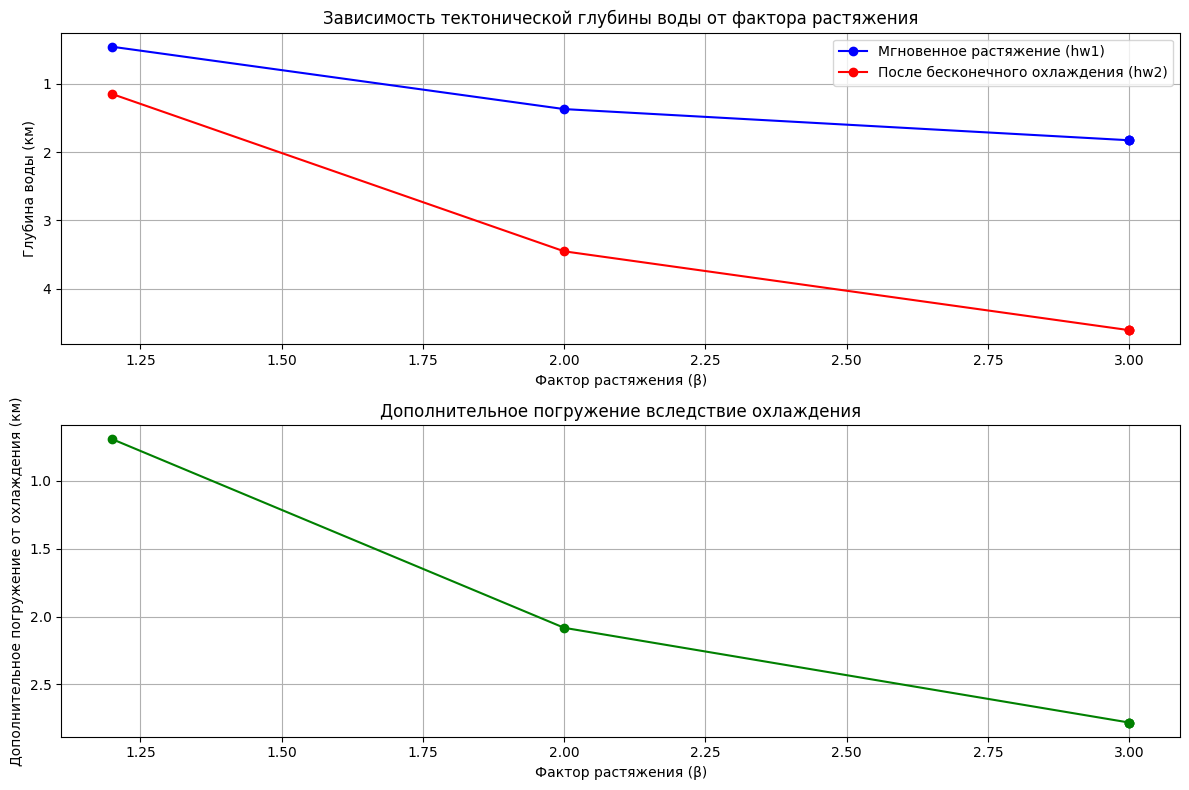


Примеры значений:

Для β = 1.20:
  Глубина воды при мгновенном растяжении (hw1): 0.46 км
  Глубина воды после бесконечного охлаждения (hw2): 1.15 км
  Дополнительное погружение от охлаждения: 0.69 км

Для β = 3.00:
  Глубина воды при мгновенном растяжении (hw1): 1.83 км
  Глубина воды после бесконечного охлаждения (hw2): 4.61 км
  Дополнительное погружение от охлаждения: 2.78 км


In [13]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_tectonic_water_depths(hm, hc, ρm0, ρc0, ρw, α, Ta, β):
    """
    Расчет тектонических глубин воды после мгновенного растяжения (hw1) 
    и после бесконечного охлаждения (hw2).
    
    Параметры:
    hm (float): Толщина мантии до растяжения [м]
    hc (float): Толщина коры до растяжения [м]
    ρm0 (float): Плотность мантии при 0°C [кг/м³]
    ρc0 (float): Плотность коры при 0°C [кг/м³]
    ρw (float): Плотность воды [кг/м³]
    α (float): Коэффициент теплового расширения [1/°C]
    Ta (float): Температура астеносферы [°C]
    β (float): Фактор растяжения (β > 1)
    
    Возвращает:
    tuple: (hw1, hw2) глубины воды в метрах
    """
    
    # Расчет hw1 (мгновенное растяжение)
    numerator_hw1 = (hm + hc) * (
        (ρm0 - ρc0) * (hc / (hm + hc)) * (1 - (α * Ta * hc) / (2 * hm + 2 * hc)) - 
        (α * Ta * ρm0 / 2)
    ) * (1 - 1/β)
    denominator_hw1 = ρm0 * (1 - α * Ta) - ρw
    hw1 = numerator_hw1 / denominator_hw1
    
    # Расчет hw2 (бесконечное охлаждение)
    term1 = (ρm0 - ρc0) * hc / (ρm0 * (1 - α * Ta) - ρw)
    term2 = (1 - 1/β) - (α * Ta * hc / (2 * hm + 2 * hc)) * (1 - 1/β**2) 
    hw2 = term1 * term2
    
    return hw1, hw2

def plot_water_depths(hm, hc, ρm0, ρc0, ρw, α, Ta, β_values):
    """
    Построение графика зависимости между фактором растяжения (β) и глубинами воды (hw1, hw2)
    """
    hw1_list = []
    hw2_list = []
    cooling_subsidence = []
    
    for β in β_values:
        hw1, hw2 = calculate_tectonic_water_depths(hm, hc, ρm0, ρc0, ρw, α, Ta, β)
        hw1_list.append(hw1/1000)  # преобразование в км
        hw2_list.append(hw2/1000)  # преобразование в км
        cooling_subsidence.append((hw2-hw1)/1000)  # преобразование в км
    
    plt.figure(figsize=(12, 8))
    
    # График hw1 и hw2
    plt.subplot(2, 1, 1)
    plt.plot(β_values, hw1_list, 'bo-', label='Мгновенное растяжение (hw1)')
    plt.plot(β_values, hw2_list, 'ro-', label='После бесконечного охлаждения (hw2)')
    plt.gca().invert_yaxis()  # инвертировать ось Y (глубина увеличивается вниз)
    plt.xlabel('Фактор растяжения (β)')
    plt.ylabel('Глубина воды (км)')
    plt.title('Зависимость тектонической глубины воды от фактора растяжения')
    plt.grid(True)
    plt.legend()
    
    # График разницы между hw2 и hw1
    plt.subplot(2, 1, 2)
    plt.plot(β_values, cooling_subsidence, 'go-')
    plt.gca().invert_yaxis()
    plt.xlabel('Фактор растяжения (β)')
    plt.ylabel('Дополнительное погружение от охлаждения (км)')
    plt.title('Дополнительное погружение вследствие охлаждения')
    plt.grid(True)
    
    plt.tight_layout()

    plt.savefig('ПОГРУЖЕНИЕ.png',
               dpi=300,                  
               bbox_inches='tight',    
               pad_inches=0.05,          
               facecolor='white',        
               edgecolor='none',         
               transparent=False,        
               )
    
    plt.show()
    
    return hw1_list, hw2_list, cooling_subsidence

# Пример использования
if __name__ == "__main__":
    # Входные параметры (примерные значения)
    hm = 95e3      # толщина мантии [м]
    hc = 30e3      # толщина коры [м]
    ρm0 = 3300      # плотность мантии при 0°C [кг/м³]
    ρc0 = 2800      # плотность коры при 0°C [кг/м³]
    ρw = 1000       # плотность воды [кг/м³]
    α = 3.28e-5     # коэффициент теплового расширения [1/°C]
    Ta = 1333       # температура астеносферы [°C]
    β_values = np.array([1.2, 2, 3, 3, 3])  # тестируемые факторы растяжения
    
    # Расчет и построение графиков
    print("Расчет тектонических глубин воды")
    print("--------------------------------")
    print(f"Входные параметры:")
    print(f"Толщина мантии (hm): {hm/1000} км")
    print(f"Толщина коры (hc): {hc/1000} км")
    print(f"Плотность мантии (ρm0): {ρm0} кг/м³")
    print(f"Плотность коры (ρc0): {ρc0} кг/м³")
    print(f"Плотность воды (ρw): {ρw} кг/м³")
    print(f"Коэффициент теплового расширения (α): {α} 1/°C")
    print(f"Температура астеносферы (Ta): {Ta} °C")
    
    hw1_list, hw2_list, cooling_subsidence = plot_water_depths(hm, hc, ρm0, ρc0, ρw, α, Ta, β_values)
    
    # Вывод некоторых примеров значений
    print("\nПримеры значений:")
    for i, β in enumerate(β_values[::4]):  # вывод каждого 4-го значения
        print(f"\nДля β = {β:.2f}:")
        print(f"  Глубина воды при мгновенном растяжении (hw1): {hw1_list[i*4]:.2f} км")
        print(f"  Глубина воды после бесконечного охлаждения (hw2): {hw2_list[i*4]:.2f} км")
        print(f"  Дополнительное погружение от охлаждения: {cooling_subsidence[i*4]:.2f} км")

# Радиогенный нагрев 

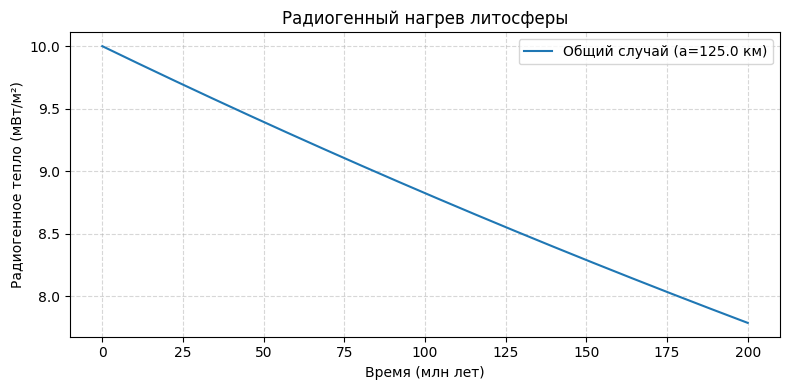

In [14]:
SEC_IN_YEAR = 365.25 * 24 * 3600  # секунд в году
TAU_R = 800e6 * SEC_IN_YEAR  # характерное время затухания (800 млн лет в секундах)

# Параметры по умолчанию
A0 = 1.0e-6  # поверхностная генерация тепла (Вт/м³)
a_r = 10000  # масштаб глубины затухания (м)
a = 125e3  # толщина литосферы (м)
rho_r = 2700  # плотность породы (кг/м³)
U = 2.0  # концентрация урана (ppm)
Th = 8.0  # концентрация тория (ppm)
K = 1.5  # концентрация калия (%)

def calculate_radiogenic_heat(time_yr, A0, a_r, a, rho_r, U, Th, K):
    """Вычисление радиогенного тепла"""
    time_sec = time_yr * SEC_IN_YEAR
    if A0 is None:
        Q_r = 0.01 * rho_r * (9.52 * U + 2.56 * Th + 3.48 * K)
        A0 = Q_r * 1e-6  
    Q_rad = A0 * a_r * (1 - np.exp(-a / a_r)) * np.exp(-time_sec / TAU_R)
    if a < 0.1 * a_r:
        Q_rad = A0 * a_r * np.exp(-time_sec / TAU_R)
    return Q_rad

# Временной диапазон (0-200 млн лет)
time_range = np.linspace(0, 200e6, 1000)

Q_general = [calculate_radiogenic_heat(t, A0, a_r, a, rho_r, U, Th, K) for t in time_range]
Q_rybach = [calculate_radiogenic_heat(t, None, a_r, a, rho_r, U, Th, K) for t in time_range]  

plt.figure(figsize=(8, 4))
plt.plot(time_range/1e6, np.array(Q_general)*1e3, label=f'Общий случай (a={a/1000} км)')

plt.xlabel('Время (млн лет)')
plt.ylabel('Радиогенное тепло (мВт/м²)')
plt.title('Радиогенный нагрев литосферы')
plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.5)

plt.gca().xaxis.set_major_formatter(ScalarFormatter())
plt.gca().yaxis.set_major_formatter(ScalarFormatter())

plt.tight_layout()

plt.savefig('РАДИОГЕННЫЙ НАГРЕВ.png',
           dpi=300,                  
           bbox_inches='tight',    
           pad_inches=0.05,          
           facecolor='white',        
           edgecolor='none',         
           transparent=False,        
           )

plt.show()

# Тепловой поток

## Модель равномерного растяжения Маккензи 

### Тепловой поток во время фазы растяжения

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf
from scipy.integrate import solve_ivp, trapezoid
from scipy.optimize import root_scalar

# Параметры модели (все в размерных единицах)
a = 125e3  # толщина литосферы [м]
kappa = 8.04e-7  # температуропроводность [м²/с]
k = 3.138  # теплопроводность [Вт/(м·K)]
T1 = 1330  # температура астеносферы [°C]
beta = 4  # фактор растяжения
G_prime_values = [5, 10, 20, 50, 100]  # значения параметра G'

# Коэффициенты перевода единиц
mW_per_m2_to_mkcal = 0.0238846  # 1 мВт/м² = 0.0238846 μcal·cm⁻²·sec⁻¹

class McKenzieThermalModel:
    def __init__(self, G_prime, n_eigenvalues=30, z_resolution=1000):
        self.G_prime = G_prime
        self.n_eigenvalues = n_eigenvalues
        self.z_points = np.linspace(0, 1, z_resolution)
        self.eigenvalues = []
        self.eigenfunctions = []
        self.dtheta_n = []
        self.coefficients = []
        
    def diff_eq(self, z, y, K):
        theta, dtheta = y
        return [dtheta, -self.G_prime*(1-z)*dtheta - K*theta]
    
    def propagator_matrix(self, K):
        sol = solve_ivp(lambda z, y: self.diff_eq(z, y, K), 
                       (0, 1), [0, 1], method='RK45', dense_output=True)
        return sol.sol(1)[0]
    
    def find_eigenvalues(self):
        K_guesses = [(n+1)**2 * np.pi**2 + self.G_prime/2 for n in range(self.n_eigenvalues)]
        for guess in K_guesses:
            try:
                res = root_scalar(self.propagator_matrix, x0=guess, method='newton',
                                fprime=lambda K: (self.propagator_matrix(K+1e-6) - self.propagator_matrix(K-1e-6))/2e-6)
                if res.converged and res.root > 0:
                    self.eigenvalues.append(res.root)
            except:
                continue
        self.eigenvalues = sorted(list(set(self.eigenvalues)))[:self.n_eigenvalues]
    
    def compute_eigenfunctions(self):
        for K in self.eigenvalues:
            sol = solve_ivp(lambda z, y: self.diff_eq(z, y, K), 
                          (0, 1), [0, 1], t_eval=self.z_points, method='RK45')
            self.eigenfunctions.append(sol.y[0])
    
    def compute_derivatives(self):
        for K in self.eigenvalues:
            sol = solve_ivp(lambda z, y: self.diff_eq(z, y, K), 
                          (0, 1), [0, 1], t_eval=[1], method='RK45')
            self.dtheta_n.append(sol.y[1][0])
    
    def _compute_normalization(self, theta_n):
        integrand = np.exp((self.z_points - 1)**2 * self.G_prime/2) * theta_n**2
        return trapezoid(integrand, self.z_points)
    
    def _compute_coefficient(self, initial_condition, theta_n, norm):
        integrand = initial_condition(self.z_points) * theta_n * np.exp((self.z_points - 1)**2 * self.G_prime/2)
        return trapezoid(integrand, self.z_points) / norm
    
    def compute_coefficients(self):
        def initial_condition(z):
            return (1 - z) + erf((z - 1) * np.sqrt(self.G_prime/2)) / erf(np.sqrt(self.G_prime/2))
        
        for theta_n in self.eigenfunctions:
            norm = self._compute_normalization(theta_n)
            an = self._compute_coefficient(initial_condition, theta_n, norm)
            self.coefficients.append(an)
    
    def heat_flow_during_stretching(self, t):
        """Тепловой поток во время растяжения в мВт/м²"""
        t_scale = kappa * t / a**2
        
        # Основные члены в размерной форме
        steady_flow = (k * T1 / a) * np.sqrt(2 * self.G_prime / np.pi) / erf(np.sqrt(self.G_prime / 2))
        
        transient_flow = 0
        for an, Kn, dtheta in zip(self.coefficients, self.eigenvalues, self.dtheta_n):
            transient_flow += (k * T1 / a) * an * dtheta * np.exp(-Kn * t_scale)
        
        return (steady_flow - transient_flow) * 1e3  # Переводим в мВт/м²

    def compute_post_rift_coefficients(self):
        """Коэффициенты для пост-рифтинга в размерной форме"""
        z_points = self.z_points
        T_final = np.zeros_like(z_points)
        
        # Стационарный член в размерных единицах
        T_final += -(k * T1 / a) * erf((z_points - 1) * np.sqrt(self.G_prime/2)) / erf(np.sqrt(self.G_prime/2))
        
        t_final = (a**2 * np.log(beta)) / (kappa * self.G_prime)
        t_scale = kappa * t_final / a**2
        
        # Транзиентные члены в размерных единицах
        for an, Kn, theta_n in zip(self.coefficients, self.eigenvalues, self.eigenfunctions):
            T_final += (k * T1 / a) * an * np.exp(-Kn * t_scale) * theta_n
        
        b_coeffs = []
        for n in range(1, self.n_eigenvalues + 1):
            integrand = (T_final + (k * T1 / a) * (z_points - 1)) * np.sin(n * np.pi * z_points)
            bn = 2 * trapezoid(integrand, z_points) / (k * T1 / a)  # Нормировка
            b_coeffs.append(bn)
        
        return b_coeffs

    def heat_flow_post_rift(self, t_post, b_coeffs):
        """Тепловой поток после растяжения в мВт/м²"""
        t_scale = kappa * t_post / a**2
        
        # Стационарный поток в размерных единицах
        steady_flow = k * T1 / a
        
        transient_flow = 0
        for n, bn in enumerate(b_coeffs, start=1):
            transient_flow += (k * T1 / a) * np.pi * n * bn * (-1)**(n+1) * np.exp(-n**2 * np.pi**2 * t_scale)
        
        return (steady_flow + transient_flow) * 1e3  # Переводим в мВт/м²

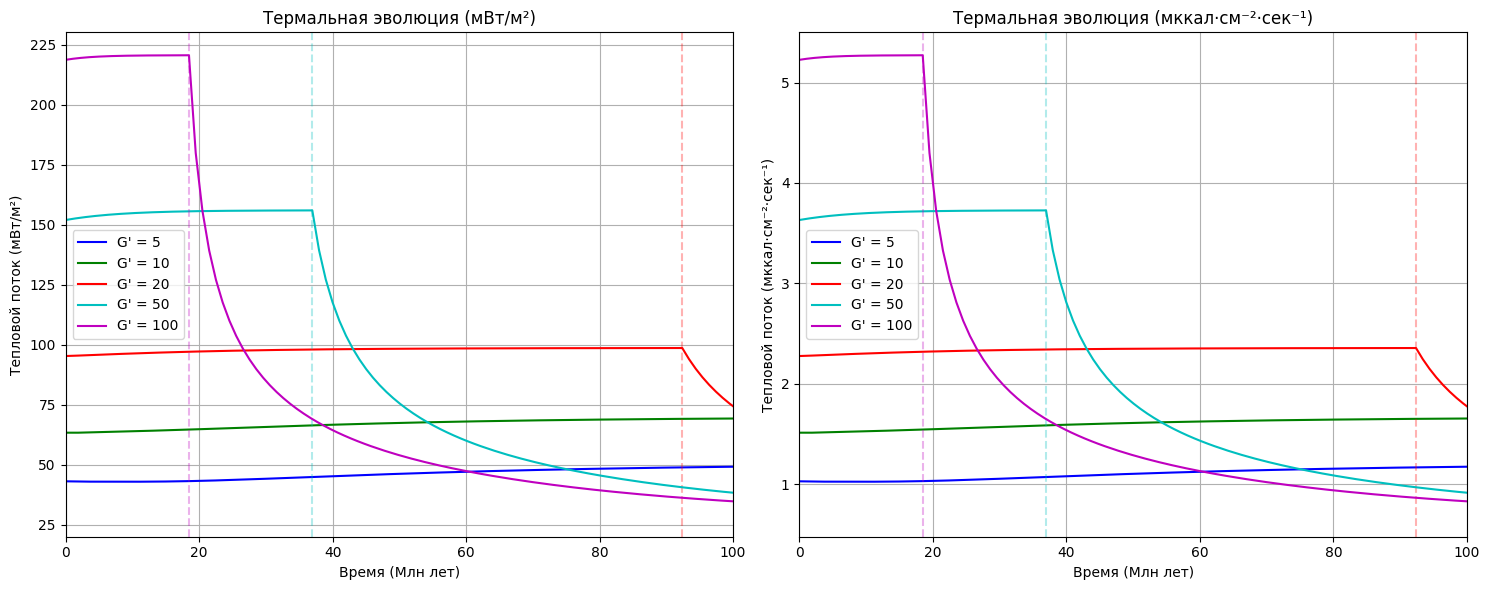

In [15]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
for G_prime, color in zip(G_prime_values, ['b', 'g', 'r', 'c', 'm']):
    duration = (a**2 * np.log(beta)) / (kappa * G_prime)
    duration_myr = duration / (1e6 * 365.25 * 24 * 3600)
    
    model = McKenzieThermalModel(G_prime)
    model.find_eigenvalues()
    model.compute_eigenfunctions()
    model.compute_derivatives()
    model.compute_coefficients()
    b_coeffs = model.compute_post_rift_coefficients()
    
    time_stretch = np.linspace(0, duration, 100)
    F_stretch = [model.heat_flow_during_stretching(t) for t in time_stretch]
    t_stretch_myr = time_stretch / (1e6 * 365.25 * 24 * 3600)
    
    time_post = np.linspace(0, 100e6*365.25*24*3600, 100)
    F_post = [model.heat_flow_post_rift(t, b_coeffs) for t in time_post]
    t_post_myr = time_post / (1e6 * 365.25 * 24 * 3600) + duration_myr
    
    plt.plot(np.concatenate([t_stretch_myr, t_post_myr]), 
             np.concatenate([F_stretch, F_post]), 
             color, label=f"G' = {G_prime}")
    plt.axvline(duration_myr, color=color, ls='--', alpha=0.3)

plt.xlabel('Время (Млн лет)')
plt.ylabel('Тепловой поток (мВт/м²)')
plt.title('Термальная эволюция (мВт/м²)')
plt.legend()
plt.grid(True)
plt.xlim(0, 100)

plt.subplot(1, 2, 2)
for G_prime, color in zip(G_prime_values, ['b', 'g', 'r', 'c', 'm']):
    duration = (a**2 * np.log(beta)) / (kappa * G_prime)
    duration_myr = duration / (1e6 * 365.25 * 24 * 3600)
    
    model = McKenzieThermalModel(G_prime)
    model.find_eigenvalues()
    model.compute_eigenfunctions()
    model.compute_derivatives()
    model.compute_coefficients()
    b_coeffs = model.compute_post_rift_coefficients()
    
    time_stretch = np.linspace(0, duration, 100)
    F_stretch = [model.heat_flow_during_stretching(t) * mW_per_m2_to_mkcal for t in time_stretch]
    t_stretch_myr = time_stretch / (1e6 * 365.25 * 24 * 3600)
    
    time_post = np.linspace(0, 100e6*365.25*24*3600, 100)
    F_post = [model.heat_flow_post_rift(t, b_coeffs) * mW_per_m2_to_mkcal for t in time_post]
    t_post_myr = time_post / (1e6 * 365.25 * 24 * 3600) + duration_myr
    
    plt.plot(np.concatenate([t_stretch_myr, t_post_myr]), 
             np.concatenate([F_stretch, F_post]), 
             color, label=f"G' = {G_prime}")
    plt.axvline(duration_myr, color=color, ls='--', alpha=0.3)

plt.xlabel('Время (Млн лет)')
plt.ylabel('Тепловой поток (мккал·см⁻²·сек⁻¹)')
plt.title('Термальная эволюция (мккал·см⁻²·сек⁻¹)')
plt.legend()
plt.grid(True)
plt.xlim(0, 100)

plt.tight_layout()

plt.savefig('ТЕПЛОВОЙ ПОТОК - ОДНОСЛОЙНАЯ МОДЕЛЬ.png',
           dpi=300,                  
           bbox_inches='tight',    
           pad_inches=0.05,          
           facecolor='white',        
           edgecolor='none',         
           transparent=False,        
           )

plt.show()

### Тепловой поток во время фазы охлаждения

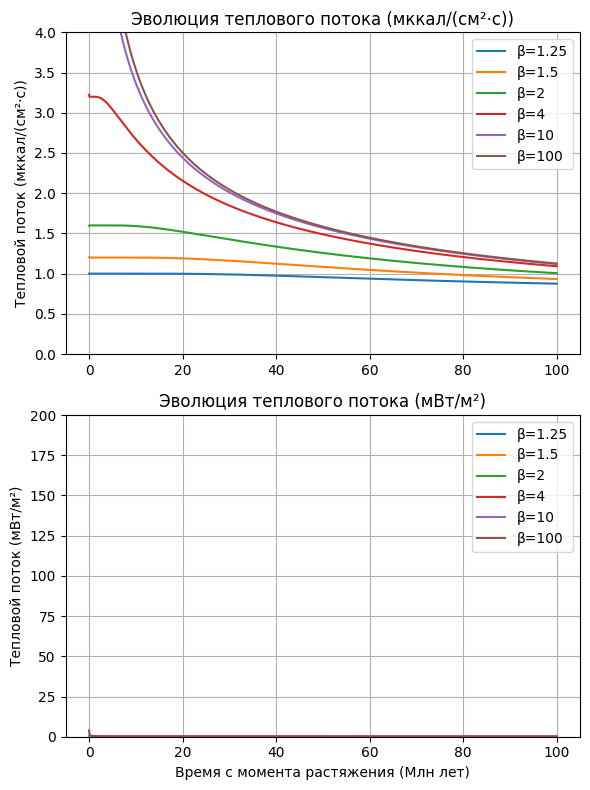

In [22]:
def calculate_heat_flow_main(
    beta: float,
    t: Union[float, np.ndarray],
    Q_const: float = 63e-3,
    constant: bool = False,
    a: float = 1.25e7,
    k: float = 0.00804,
    lam: float = 0.0075,
    T1: float = 1333,
    n_terms: int = 100
) -> Union[float, np.ndarray]:
    """
    Расчет теплового потока для моделей растяжения литосферы.
    Все значения времени должны быть в миллионах лет.
    Возвращает значения в µкал/(см²·с) и мВт/м².
    """
    if constant:
        heat_flow_mkcal = Q_const * 1e7 / 4.184
        heat_flow_mw = Q_const * 1e3
        return heat_flow_mkcal, heat_flow_mw

    if beta <= 0:
        raise ValueError("Коэффициент растяжения beta должен быть положительным")
    if np.any(t < 0):
        raise ValueError("Время t должно быть неотрицательным")

    # Константы преобразования
    MYR_IN_SEC = 1e6 * 3.154e7  # миллионов лет в секундах
    a_cm = a  # толщина литосферы в см
    k_cm2s = k  # температуропроводность в см²/с

    # Характерное время термической релаксации
    tau_s = (a_cm**2) / (np.pi**2 * k_cm2s)
    tau_myr = tau_s / MYR_IN_SEC

    # Расчет ряда Фурье
    n = np.arange(1, n_terms + 1)
    exponent = -np.outer(n**2, t) / tau_myr
    sin_term = np.sin(n * np.pi / beta) / (n * np.pi)
    Cn = (beta * sin_term[:, np.newaxis]) * np.exp(exponent)
    F_sum = np.sum(Cn, axis=0)

    # Расчет теплового потока
    heat_flow_cal = (lam * T1 / a_cm) * (1 + 2 * F_sum)
    heat_flow_mkcal = heat_flow_cal * 1e6  # преобразование в мккал/(см²·с)
    heat_flow_mw = heat_flow_cal * 41868   # преобразование в мВт/м²

    return heat_flow_mkcal, heat_flow_mw

# Временной диапазон (0-100 млн лет)
t_myr = np.linspace(0, 100, 1000)
betas = [1.25, 1.5, 2, 4, 10, 100]

# Создание графиков
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8))

for beta in betas:
    heat_flow_mkcal, heat_flow_mw = calculate_heat_flow_main(beta=beta, t=t_myr)
    
    ax1.plot(t_myr, heat_flow_mkcal, '-', linewidth=1.5, label=f'β={beta}')
    ax2.plot(t_myr, heat_flow_mw, '-', linewidth=1.5, label=f'β={beta}')

# Настройка верхнего графика (мккал/(см²·с))
ax1.set_title("Эволюция теплового потока (мккал/(см²·с))")
ax1.set_ylabel("Тепловой поток (мккал/(см²·с))")
ax1.grid(True)
ax1.legend()
ax1.set_ylim(0, 4)

# Настройка нижнего графика (мВт/м²)
ax2.set_title("Эволюция теплового потока (мВт/м²)")
ax2.set_xlabel("Время с момента растяжения (Млн лет)")
ax2.set_ylabel("Тепловой поток (мВт/м²)")
ax2.grid(True)
ax2.legend()
ax2.set_ylim(0, 200)

plt.tight_layout()

# Сохранение графика
plt.savefig('ЭВОЛЮЦИЯ ТЕПЛОВОГО ПОТОКА.png',
           dpi=300,                  
           bbox_inches='tight',    
           pad_inches=0.05,          
           facecolor='white',        
           edgecolor='none',         
           transparent=False)

plt.show()

## Двухслойная модель Хеллингер и Склейтер

### Тепловой поток во время фазы растяжения

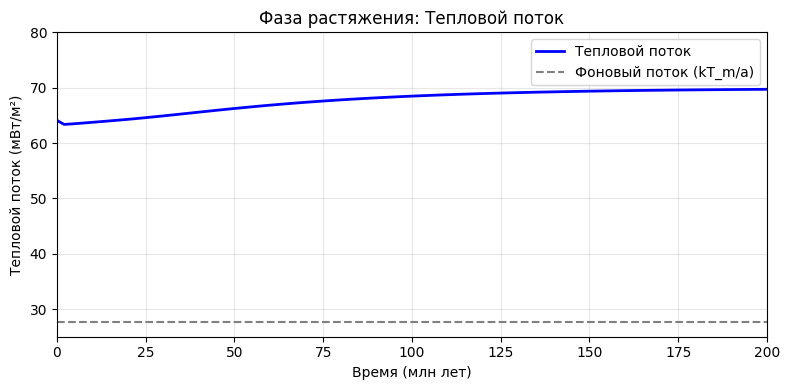

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf
from scipy.integrate import solve_ivp, trapezoid
from scipy.optimize import root_scalar

# Параметры модели
a = 125e3  # толщина литосферы (м)
t_c = 30e3  # толщина коры (м)
kappa = 1.234 * 1e-6   # тепловая диффузия (m^2/s)
k = 2.6  # теплопроводность (W/m/K)
T_m = 1330  # температура астеносферы (°C)
beta_c = 1.2  # коэффициент растяжения коры
beta_sc = 1.2  # коэффициент растяжения субкоровой литосферы
G_prime = 10  # безразмерный параметр
duration_myr = 200  # продолжительность растяжения (млн лет)
duration = duration_myr * (1e6 * 365.25 * 24 * 3600)  # в секундах

# Эквивалентное растяжение всей литосферы
beta_L = 1 / ((t_c/a)/beta_c + (1 - t_c/a)/beta_sc)

class TwoLayerMcKenzieModel:
    def __init__(self, beta_c, beta_sc, G_prime=10, n_eigenvalues=10):
        self.beta_c = beta_c
        self.beta_sc = beta_sc
        self.G_prime = G_prime
        self.n_eigenvalues = n_eigenvalues
        self.z_points = np.linspace(0, 1, 1000)
        
        self.gamma_c = 1 - 1/beta_c
        self.gamma_sc = 1 - 1/beta_sc
        self.gamma_L = (t_c/a)*self.gamma_c + (1 - t_c/a)*self.gamma_sc
        
        self.eigenvalues = []
        self.eigenfunctions = []
        self.dtheta_n = []
        self.coefficients = []
    
    def diff_eq(self, z, y, K):
        theta, dtheta = y
        return [dtheta, -self.G_prime*(1-z)*dtheta - K*theta]
    
    def propagator_matrix(self, K):
        sol = solve_ivp(lambda z, y: self.diff_eq(z, y, K), 
                        (0, 1), [0, 1], method='RK45', dense_output=True)
        return sol.sol(1)[0]
    
    def find_eigenvalues(self):
        K_guesses = [(n+1)**2 * np.pi**2 + self.G_prime/2 for n in range(self.n_eigenvalues)]
        for guess in K_guesses:
            try:
                res = root_scalar(self.propagator_matrix, x0=guess, method='newton',
                                  fprime=lambda K: (self.propagator_matrix(K+1e-6) - self.propagator_matrix(K-1e-6))/2e-6)
                if res.converged and res.root > 0:
                    self.eigenvalues.append(res.root)
            except:
                continue
        self.eigenvalues = sorted(list(set(self.eigenvalues))[:self.n_eigenvalues])
    
    def compute_eigenfunctions(self):
        for K in self.eigenvalues:
            sol = solve_ivp(lambda z, y: self.diff_eq(z, y, K), 
                           (0, 1), [0, 1], t_eval=self.z_points, method='RK45')
            self.eigenfunctions.append(sol.y[0])
    
    def compute_derivatives(self):
        for K in self.eigenvalues:
            sol = solve_ivp(lambda z, y: self.diff_eq(z, y, K), 
                           (0, 1), [0, 1], t_eval=[1], method='RK45')
            self.dtheta_n.append(sol.y[1][0])
    
    def _compute_normalization(self, theta_n):
        integrand = np.exp((self.z_points - 1)**2 * self.G_prime/2) * theta_n**2
        return trapezoid(integrand, self.z_points)
    
    def _compute_coefficient(self, initial_condition, theta_n, norm):
        integrand = initial_condition(self.z_points) * theta_n * np.exp((self.z_points - 1)**2 * self.G_prime/2)
        return trapezoid(integrand, self.z_points) / norm
    
    def compute_coefficients(self):
        def initial_condition(z):
            return (1 - z) + erf((z - 1) * np.sqrt(self.G_prime/2)) / erf(np.sqrt(self.G_prime/2))
        
        for theta_n in self.eigenfunctions:
            norm = self._compute_normalization(theta_n)
            an = self._compute_coefficient(initial_condition, theta_n, norm)
            self.coefficients.append(an)
    
    def heat_flow_during_stretching(self, t):
        t_dimless = kappa * t / (a**2 * self.beta_sc**2)
        steady_term = np.sqrt(2 * self.G_prime / np.pi) / erf(np.sqrt(self.G_prime / 2))
        transient_term = 0
        for an, Kn, dtheta in zip(self.coefficients, self.eigenvalues, self.dtheta_n):
            transient_term += an * np.exp(-Kn * t_dimless) * dtheta
        return (k * T_m / a) * (steady_term - transient_term)

model = TwoLayerMcKenzieModel(beta_c=beta_c, beta_sc=beta_sc, G_prime=G_prime)
model.find_eigenvalues()
model.compute_eigenfunctions()
model.compute_derivatives()
model.compute_coefficients()

time_stretch = np.linspace(0, duration, 100)
F_stretch = [model.heat_flow_during_stretching(t) for t in time_stretch]
F_stretch_mW = np.array(F_stretch) * 1e3
t_stretch_myr = time_stretch / (1e6 * 365.25 * 24 * 3600)

plt.figure(figsize=(8, 4))
plt.plot(t_stretch_myr, F_stretch_mW, 'b-', linewidth=2, label='Тепловой поток')
plt.axhline(y=(k * T_m / a) * 1e3, color='gray', linestyle='--', label='Фоновый поток (kT_m/a)')
plt.xlabel('Время (млн лет)')
plt.ylabel('Тепловой поток (мВт/м²)')
plt.title('Фаза растяжения: Тепловой поток')
plt.xlim(0, 200)
plt.ylim(25, 80)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()

plt.savefig('ТЕПЛОВОЙ ПОТОК - ДВУХСЛОЙНАЯ МОДЕЛЬ - РАСТЯЖЕНИЕ.png',
           dpi=300,                  
           bbox_inches='tight',    
           pad_inches=0.05,          
           facecolor='white',        
           edgecolor='none',         
           transparent=False,        
           )
plt.show()

### Тепловой поток во время фазы охлаждения

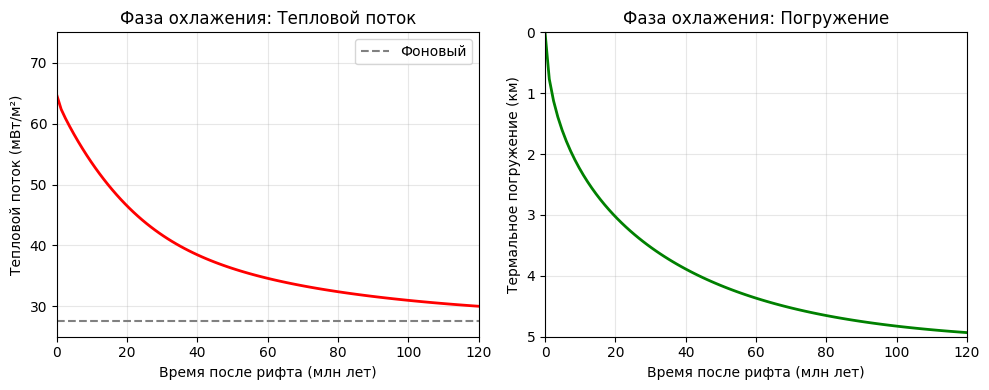

In [26]:
def compute_post_rift_coefficients(model):
    """Вычисление коэффициентов b_n для пост-рифтовой фазы"""
    z_points = model.z_points
    T_final = np.zeros_like(z_points)
    
    # Стационарный член
    T_final += -erf((z_points - 1) * np.sqrt(model.G_prime/2)) / erf(np.sqrt(model.G_prime/2))
    
    # Транзиентный член
    t_final = (a**2 * np.log(beta_L)) / (kappa * model.G_prime)
    t_dimless = kappa * t_final / a**2
    
    for an, Kn, theta_n in zip(model.coefficients, model.eigenvalues, model.eigenfunctions):
        T_final += an * np.exp(-Kn * t_dimless) * theta_n
    
    # Коэффициенты b_n через разложение в ряд Фурье
    b_coeffs = []
    for n in range(1, model.n_eigenvalues + 1):
        integrand = (T_final + (z_points - 1)) * np.sin(n * np.pi * z_points)
        bn = 2 * trapezoid(integrand, z_points)
        b_coeffs.append(bn)
    
    return b_coeffs

def heat_flow_post_rift(t_post, b_coeffs, a, kappa, k, T_m, beta_sc):
    """Тепловой поток после растяжения"""
    t_dimless = kappa * t_post / (a**2 * beta_sc**2)
    steady_term = 1
    transient_term = 0
    for n, bn in enumerate(b_coeffs, start=1):
        transient_term += n * bn * (-1)**(n+1) * np.exp(-n**2 * np.pi**2 * t_dimless)
    return (k * T_m / a) * (steady_term + np.pi * transient_term)

def thermal_subsidence(t_post_years, a, kappa, alpha, rho_m, rho_w, T_m):
    """Термальное погружение после растяжения"""
    tau = a**2 / (np.pi**2 * kappa)  # характерное время (сек)
    t_post_sec = t_post_years * 1e6 * 365.25 * 24 * 3600
    subsidence = 0
    for n in range(1, 20):
        term = (1 - np.exp(-n**2 * t_post_sec / tau)) / n**2
        subsidence += term
    return (4 * a * alpha * rho_m * T_m / (np.pi**2 * (rho_m - rho_w))) * subsidence * 1e-3  # в км

# Расчёт коэффициентов после растяжения
b_coeffs = compute_post_rift_coefficients(model)

# Время после рифта: 0–120 млн лет
time_post_myr = np.linspace(0, 120, 100)
time_post_sec = time_post_myr * 1e6 * 365.25 * 24 * 3600

# Тепловой поток
F_post = [heat_flow_post_rift(t, b_coeffs, a, kappa, k, T_m, beta_sc) for t in time_post_sec]
F_post_mW = np.array(F_post) * 1e3

# Погружение
alpha = params['alpha']
rho_m, rho_w = params['rho_m'], params['rho_w']

S_t = [thermal_subsidence(t, a, kappa, alpha, rho_m, rho_w, T_m) for t in time_post_myr]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Тепловой поток
ax1.plot(time_post_myr, F_post_mW, 'r-', linewidth=2)
ax1.set_xlabel('Время после рифта (млн лет)')
ax1.set_ylabel('Тепловой поток (мВт/м²)')
ax1.set_title('Фаза охлажения: Тепловой поток')
ax1.set_xlim(0, 120)
ax1.set_ylim(25, 75)
ax1.grid(True, alpha=0.3)
ax1.axhline(y=(k * T_m / a) * 1e3, color='gray', linestyle='--', label='Фоновый')
ax1.legend()

# Погружение
ax2.plot(time_post_myr, S_t, 'g-', linewidth=2)
ax2.set_xlabel('Время после рифта (млн лет)')
ax2.set_ylabel('Термальное погружение (км)')
ax2.set_title('Фаза охлажения: Погружение')
ax2.set_xlim(0, 120)
ax2.set_ylim(5, 0)
ax2.grid(True, alpha=0.3)

plt.tight_layout()


plt.savefig('ТЕПЛОВОЙ ПОТОК - ДВУХСЛОЙНАЯ МОДЕЛЬ - ОХЛАЖДЕНИЕ.png',
           dpi=300,                  
           bbox_inches='tight',    
           pad_inches=0.05,          
           facecolor='white',        
           edgecolor='none',         
           transparent=False,        
           )

plt.show()

# Температурные профили

## Температура на поверхности осадконакопления (SWI)

In [27]:
import requests
import pandas as pd
import numpy as np

# Raw GitHub URL for the file
raw_url = "https://github.com/MariiaKalinina/BM/raw/main/Initial%20data/Literature%20database%20from%20PM%20for%20all%20rock%20lithotypes.xlsx"

# Download the file
response = requests.get(raw_url)
with open("literature_database.xlsx", "wb") as f:
    f.write(response.content)

# Load all sheets at once
all_sheets = pd.read_excel("literature_database.xlsx", sheet_name=None)

# Create variables for each sheet
for sheet_name, df in all_sheets.items():
    clean_name = sheet_name.replace(" ", "_").replace("-", "_")
    var_name = f"Database_{clean_name}"
    globals()[var_name] = df
    print(f"Created variable: {var_name} with shape {df.shape}")

Created variable: Database_Lithotypes with shape (215, 157)
Created variable: Database_Kinetics_all with shape (621, 293)
Created variable: Database_Secondary_cracking with shape (50, 296)
Created variable: Database_Geochronology with shape (117, 28)
Created variable: Database_SWIT_Map with shape (362, 722)
Created variable: Database_SWIT_coordinates_ with shape (28, 365)
Created variable: Database_Global_eustatic_curve with shape (5438, 50)


In [28]:
Database_SWIT_Map.head(5)

,Unnamed: 0,Time,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 712,Unnamed: 713,Unnamed: 714,Unnamed: 715,Unnamed: 716,Unnamed: 717,Unnamed: 718,Unnamed: 719,Unnamed: 720,Unnamed: 721
0,Latitude,360.0000,359.5000,359.0000,358.5000,358.0000,357.5000,357.0000,356.5000,356.0000,...,4.5,4.0,3.5,3.0,2.5,2.0,1.5,1.0,0.5,0.0
1,-90,9.2507,9.2344,9.2180,9.2015,9.1849,9.1679,9.1504,9.1323,9.1133,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
2,-89.5,9.2547,9.2381,9.2214,9.2047,9.1878,9.1705,9.1528,9.1344,9.1153,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
3,-89,9.2596,9.2426,9.2256,9.2087,9.1915,9.1740,9.1561,9.1375,9.1182,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
4,-88.5,9.2654,9.2480,9.2308,9.2135,9.1960,9.1784,9.1602,9.1415,9.1220,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0


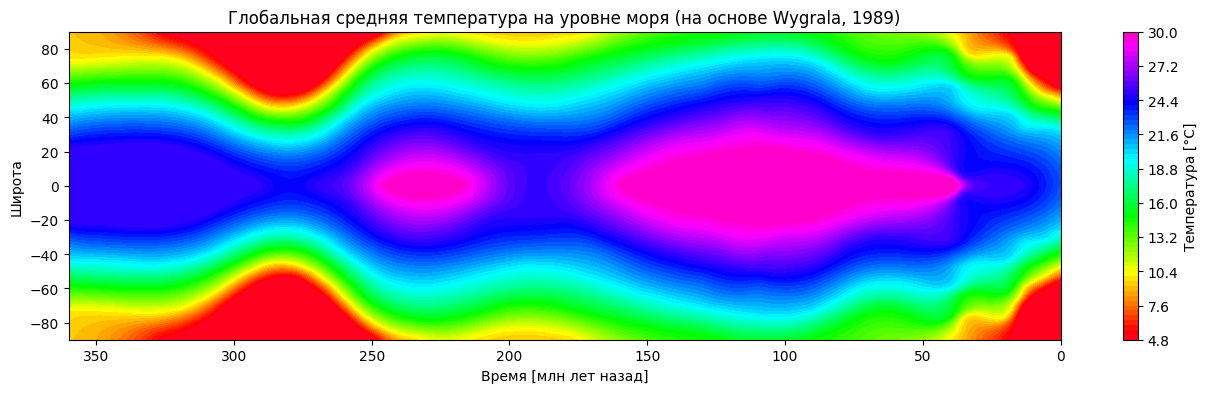

In [29]:
latitude = Database_SWIT_Map.iloc[1:, 0].astype(float).values
longitude = Database_SWIT_Map.iloc[0, 1:].astype(float).values
data_values = Database_SWIT_Map.iloc[1:, 1:].astype(float).values

Lon, Lat = np.meshgrid(longitude, latitude)
plt.figure(figsize=(16, 4))
contour = plt.contourf(Lon, Lat, data_values, cmap='gist_rainbow', levels=80)

plt.colorbar(contour, label="Температура [°C]")

plt.xlabel("Время [млн лет назад]")
plt.ylabel("Широта")
plt.title("Глобальная средняя температура на уровне моря (на основе Wygrala, 1989)")

plt.gca().invert_xaxis()
plt.savefig('SWI.png', dpi=300, bbox_inches='tight')
plt.show()

In [30]:
def process_paleolatitude_data(df: pd.DataFrame, reference_latitude: float) -> pd.DataFrame:
    cleaned_df = df[~df.iloc[:, 0].str.contains('Adjusting|If Current Latitude', na=False)]
    current_lats = pd.to_numeric(df.iloc[1:, 1], errors='coerce').dropna()
    hemispheres = df.iloc[1:, 2]
    continents = df.iloc[1:, 3]
    time_values = pd.to_numeric(df.iloc[0, 4:], errors='coerce').dropna().values
    paleo_profiles = df.iloc[1:, 4:].apply(pd.to_numeric, errors='coerce')

    results = []
    for idx, (current_lat, hemisphere, continent) in enumerate(zip(current_lats, hemispheres, continents)):
        profile = paleo_profiles.iloc[idx].dropna().values
        if len(profile) != len(time_values):
            continue

        if hemisphere == 'North' and np.isclose(current_lat, reference_latitude):
            adjusted = np.clip(profile + reference_latitude, -90, 90)
            results.append({
                'Continent': continent,
                'Hemisphere': hemisphere,
                'Current_Latitude': current_lat,
                'Time': time_values,
                'Paleolatitude': adjusted
            })
        elif hemisphere == 'South' and np.isclose(current_lat, -reference_latitude):
            adjusted = np.clip(profile - reference_latitude, -90, 90)
            results.append({
                'Continent': continent,
                'Hemisphere': hemisphere,
                'Current_Latitude': current_lat,
                'Time': time_values,
                'Paleolatitude': adjusted
            })

    if not results:
        return pd.DataFrame()

    result_df = pd.DataFrame(results)
    return result_df.explode(['Time', 'Paleolatitude']).reset_index(drop=True)


def analyze_results(result_df: pd.DataFrame) -> None:
    if result_df.empty:
        print("Совпадающие данные не найдены для заданной опорной широты")
        return

    print("\n=== Результаты анализа ===")
    print(f"Всего записей: {len(result_df)}")
    print("\nПо полушариям:")
    print(result_df['Hemisphere'].value_counts())
    print("\nПо континентам:")
    print(result_df['Continent'].value_counts())
    print("\nПример данных:")
    print(result_df.head())


if __name__ == "__main__":
    REFERENCE_LATITUDE = 90

    try:
        paleo_results = process_paleolatitude_data(
            df=Database_SWIT_coordinates_,
            reference_latitude=REFERENCE_LATITUDE
        )

        analyze_results(paleo_results)

        if not paleo_results.empty:
            north_data = paleo_results[paleo_results['Hemisphere'] == 'North']
            europe_data = paleo_results[paleo_results['Continent'] == 'Central Asia']

    except Exception as e:
        print(f"Ошибка при обработке данных: {e}")


=== Результаты анализа ===
Всего записей: 361

По полушариям:
Hemisphere
North    361
Name: count, dtype: int64

По континентам:
Continent
Europe    361
Name: count, dtype: int64

Пример данных:
  Continent Hemisphere  Current_Latitude Time Paleolatitude
0    Europe      North              90.0  0.0          90.0
1    Europe      North              90.0  1.0          89.6
2    Europe      North              90.0  2.0          89.2
3    Europe      North              90.0  3.0          89.0
4    Europe      North              90.0  4.0          88.6


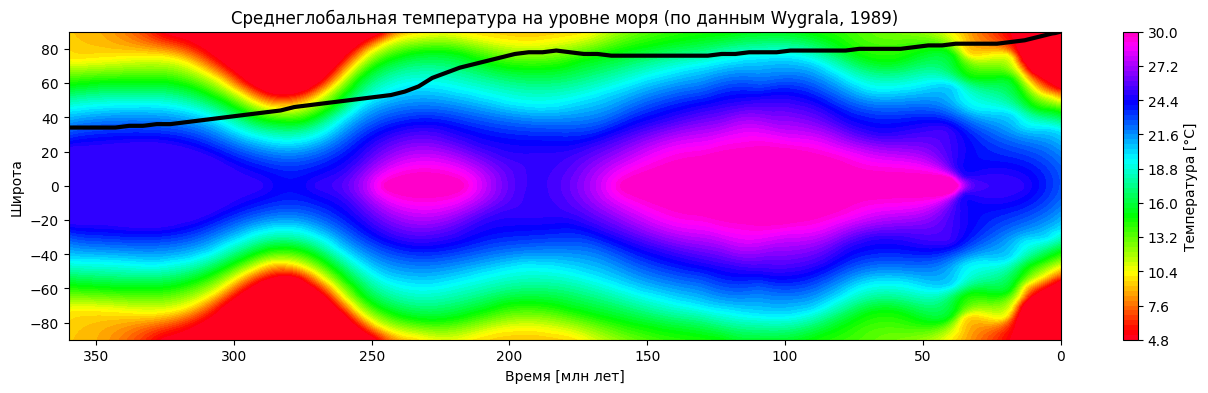

In [33]:
Lon, Lat = np.meshgrid(longitude, latitude)
plt.figure(figsize=(16, 4))
contour = plt.contourf(Lon, Lat, data_values, cmap='gist_rainbow', levels=80)

plt.plot(paleo_results["Time"], paleo_results["Paleolatitude"], color='black', lw=3)

plt.colorbar(contour, label="Температура [°C]")
plt.xlabel("Время [млн лет]")
plt.ylabel("Широта")
plt.title("Среднеглобальная температура на уровне моря (по данным Wygrala, 1989)")
plt.gca().invert_xaxis()
plt.show()

## Модель термической структуры литосферы

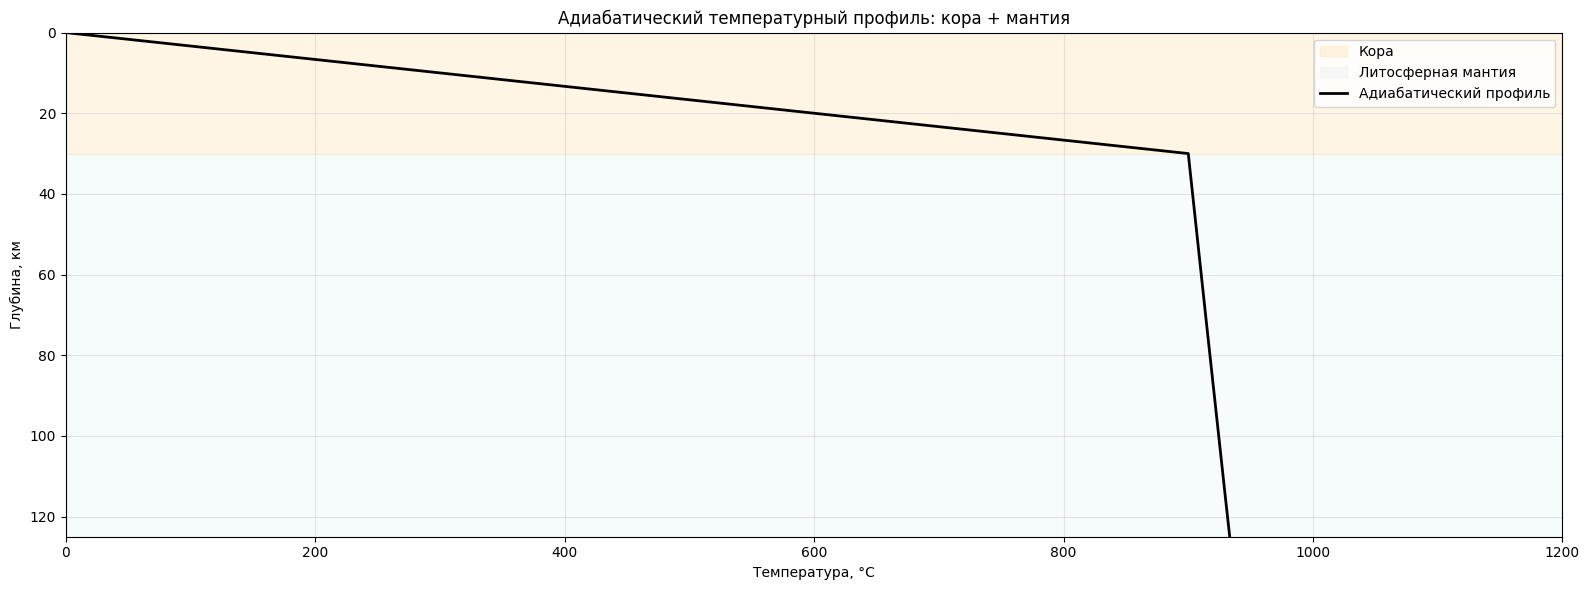

In [35]:
def adiabat_temperature_profile(
    T_surface=0,            # Температура на поверхности, °C
    thickness_crust=30e3,   # Толщина коры, м
    grad_crust=30/1e3,      # Градиент температуры в коре, °C/м
    thickness_mantle=95e3,  # Толщина мантии, м
    alpha=3e-5,             # Коэффициент теплового расширения, 1/К
    g=9.8,                  # Ускорение свободного падения, м/с²
    Cp=1000                 # Изобарная теплоёмкость, Дж/(кг·К)
):
    # Расчёт температуры в коре (линейный градиент)
    z_crust = np.linspace(0, thickness_crust, 300)
    T_crust = T_surface + grad_crust * z_crust

    # Температура на границе кора-мантия
    T_base_crust = T_crust[-1]

    # Расчёт температуры в мантии (адиабата)
    z_mantle = np.linspace(thickness_crust, thickness_crust + thickness_mantle, 500)
    T0_K = T_base_crust + 273.15  # в Кельвины

    exponent = (alpha * g / Cp) * (z_mantle - thickness_crust)
    T_mantle_K = T0_K * np.exp(exponent)
    T_mantle = T_mantle_K - 273.15  

    z_total = np.concatenate((z_crust, z_mantle)) / 1e3  
    T_total = np.concatenate((T_crust, T_mantle))

    plt.figure(figsize=(16, 6))
    
    plt.axhspan(0, thickness_crust / 1e3, color='orange', alpha=0.1, label='Кора')
    plt.axhspan(thickness_crust / 1e3, (thickness_crust + thickness_mantle) / 1e3, 
                color='lightblue', alpha=0.1, label='Литосферная мантия')


    plt.plot(T_total, z_total, color='black', linewidth=2, label='Адиабатический профиль')

    plt.gca().invert_yaxis()
    plt.xlim(0, 1200)
    plt.ylim(125, 0)
    plt.xlabel('Температура, °C')
    plt.ylabel('Глубина, км')
    plt.title('Адиабатический температурный профиль: кора + мантия')
    plt.grid(True, alpha=0.3)
    
    plt.legend()
    plt.tight_layout()
    plt.savefig('ТЕМПЕРАТУРНЫЙ ПРОФИЛЬ - КОРА - МАНТИЯ.png',
               dpi=300,                  
               bbox_inches='tight',    
               pad_inches=0.05,          
               facecolor='white',        
               edgecolor='none',         
               transparent=False,        
               )
    
    plt.show()

adiabat_temperature_profile()

### Температуратурные профили во время фазы растяжения

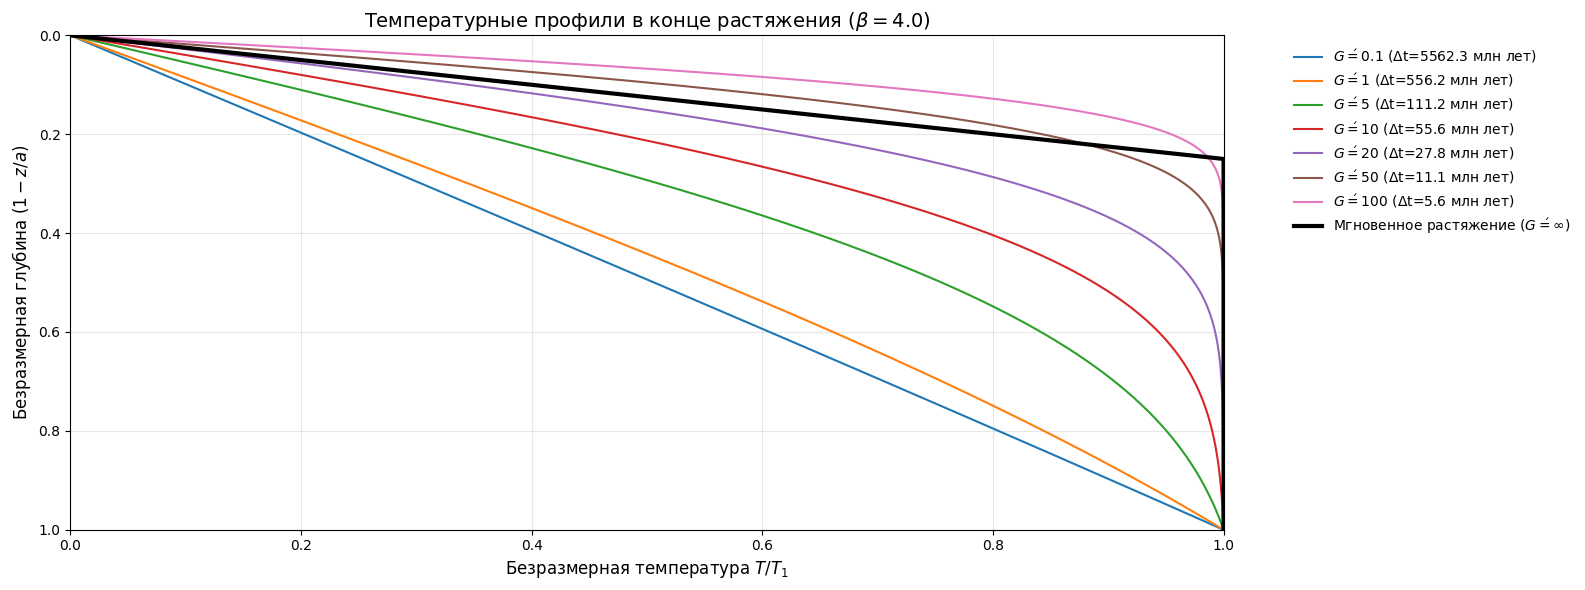

In [40]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

# Константы
seconds_per_Myr = 1e6 * 365.25 * 24 * 3600

# Параметры модели
params = {
    'a': 125e3,
    'kappa': 1.234e-6,
    'T_m': 1330,
    'beta_c': 1.2,
    'beta_sc': 1.2,
    'G_prime': 10,
    'duration_myr': 200
}

a = params['a']
kappa = params['kappa']
T1 = params['T_m']

beta = 4.0
G_prime_values = [0.1, 1, 5, 10, 20, 50, 100, np.inf]
z_prime = np.linspace(0, 1, 1000)


def steady_state_temperature(z_prime, G_prime, T1):
    if G_prime == np.inf:
        return T1 * np.ones_like(z_prime)
    with np.errstate(divide='ignore', invalid='ignore'):
        numerator = erf((z_prime - 1) * np.sqrt(G_prime / 2))
        denominator = erf(np.sqrt(G_prime / 2))
        ratio = np.divide(numerator, denominator, out=np.zeros_like(numerator), where=denominator != 0)
    return -T1 * ratio


class ApproxSolution:
    def __init__(self, K, z, theta_z):
        self.p = [K]
        self.z = z
        self.theta_z = theta_z

    def __call__(self, z):
        theta_interp = np.interp(z, self.z, self.theta_z)
        dtheta_interp = np.gradient(theta_interp, z)
        return np.vstack([theta_interp, dtheta_interp])


def solve_eigenproblem(G_prime, n_eigenvalues=5):
    if G_prime >= 50:
        z = np.linspace(0, 1, 5000)
        boundary_layer = np.exp(-G_prime * (1 - z) / 2)
        theta_z = boundary_layer * np.sin(np.pi * z)
        K = 2 * G_prime
        sol = ApproxSolution(K, z, theta_z)
        return [K], [sol]

    def ode(z, y, p):
        return [y[1], -G_prime * (z - 1) * y[1] - p[0] * y[0]]

    def bc(ya, yb, p):
        return [ya[0], yb[0], ya[1] - 1]

    z = np.linspace(0, 1, 5000) if G_prime > 10 else np.linspace(0, 1, 2000)

    eigenvalues = []
    eigenfunctions = []

    for n in range(1, n_eigenvalues + 1):
        if G_prime < 1.0:
            K_guess = (n * np.pi) ** 2
            y_guess = np.zeros((2, len(z)))
            y_guess[0] = np.sin(n * np.pi * z)
            y_guess[1] = n * np.pi * np.cos(n * np.pi * z)
        else:
            K_guess = 2 * n * G_prime
            y = np.exp(-G_prime * (1 - z) / 2) * np.sin(n * np.pi * z)
            dy = np.gradient(y, z)
            y_guess = np.vstack([y, dy])

        y_guess[1] /= max(1e-6, abs(y_guess[1][0]))

        try:
            sol = solve_bvp(ode, bc, z, y_guess, p=[K_guess], tol=1e-3, max_nodes=50000)
            if sol.success:
                eigenvalues.append(sol.p[0])
                eigenfunctions.append(sol.sol)
        except:
            continue

    return eigenvalues, eigenfunctions


def compute_coefficients(G_prime, eigenvalues, eigenfunctions, beta, T1):
    z = np.linspace(0, 1, 10000)
    weight = np.exp((z - 1)**2 * G_prime / 2)
    T_initial = np.where(z <= (1 - 1/beta), T1, T1 * beta * (1 - z))
    T0 = steady_state_temperature(z, G_prime, T1)
    deviation = (T_initial - T0) / T1

    a_n = []
    for theta in eigenfunctions:
        theta_z = theta(z)[0]
        num = trapezoid(deviation * theta_z * weight, z)
        den = trapezoid(theta_z**2 * weight, z)
        a_n.append(num / max(1e-10, den))

    return np.array(a_n)


def temperature(z_prime, t_Myr, G_prime, T1, eigenvalues, eigenfunctions, a_n, a, kappa):
    T0 = steady_state_temperature(z_prime, G_prime, T1)
    tau = (a**2) / (np.pi**2 * kappa) / seconds_per_Myr
    t_dimless = t_Myr / tau

    transient = 0.0
    for K, theta, a_val in zip(eigenvalues, eigenfunctions, a_n):
        theta_z = theta(z_prime)[0]
        transient += a_val * theta_z * np.exp(-K * t_dimless)

    return T0 + T1 * transient


plt.figure(figsize=(16, 6))

for G_prime in G_prime_values:
    if G_prime == np.inf:
        T_model = np.where(z_prime <= (1 - 1/beta), T1, T1 * beta * (1 - z_prime))
        plt.plot(T_model / T1, 1 - z_prime, 'k-', linewidth=3, label=r'Мгновенное растяжение ($G\'=\infty$)')
        continue

    delta_t = (a**2 * np.log(beta)) / (kappa * G_prime) / seconds_per_Myr
    eigenvalues, eigenfunctions = solve_eigenproblem(G_prime, 5)

    if not eigenvalues:
        continue

    a_n = compute_coefficients(G_prime, eigenvalues, eigenfunctions, beta, T1)
    T = temperature(z_prime, delta_t, G_prime, T1, eigenvalues, eigenfunctions, a_n, a, kappa)
    label = fr'$G\'={G_prime}$ (Δt={delta_t:.1f} млн лет)'
    plt.plot(T / T1, 1 - z_prime, label=label, linewidth=1.5)

plt.xlim(0,1)
plt.ylim(0,1)
plt.gca().invert_yaxis()
plt.xlabel('Безразмерная температура $T/T_1$', fontsize=12)
plt.ylabel('Безразмерная глубина $(1 - z/a)$', fontsize=12)
plt.title(f'Температурные профили в конце растяжения ($\\beta = {beta}$)', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, frameon=False)
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.savefig('ТЕМПЕРАТУРА - РАСТЯЖЕНИЕ.png',
           dpi=300,                  
           bbox_inches='tight',    
           pad_inches=0.05,          
           facecolor='white',        
           edgecolor='none',         
           transparent=False,        
           )

plt.show()

### Температуратурные профили во время фазы охлаждения

Безразмерный параметр растяжения G' = 27.81


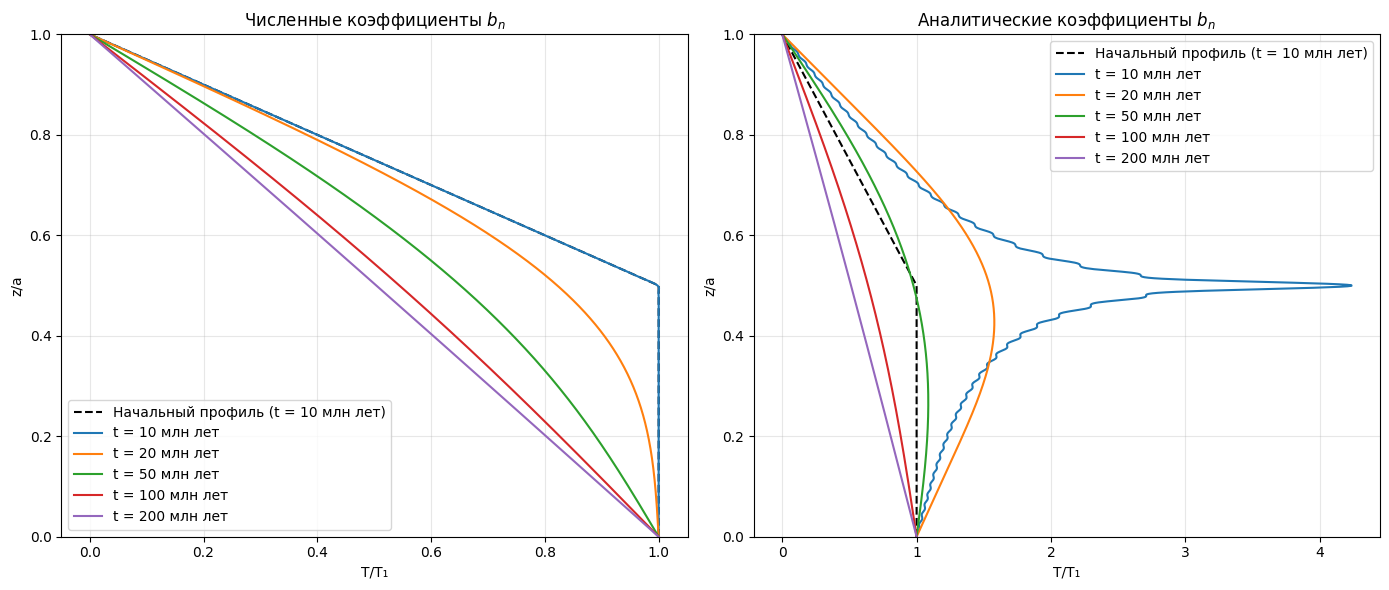

In [41]:
params = {
    'a': 125e3,           # толщина литосферы, м
    'kappa': 1.234e-6,    # тепловая диффузия, м²/с
    'T_m': 1330,          # температура астеносферы, °C
}

# Константы
seconds_per_Myr = 1e6 * 365.25 * 24 * 3600

# Параметры модели
a = params['a']
kappa = params['kappa']
T1 = params['T_m']

beta = 2.0               # коэффициент растяжения
duration_stretch_Myr = 10  # длительность растяжения, млн лет
times_after_Myr = np.array([10, 20, 50, 100, 200])  # времена после растяжения

# Пространственная сетка
z_grid = np.linspace(0, a, 1000)  # глубина, м


def initial_temperature(z, a, beta, T1):
    """Начальный температурный профиль после растяжения"""
    return np.where(z <= a * (1 - 1/beta), T1, T1 * beta * (1 - z/a))


def compute_bn_numeric(n_max, z, a, beta, T1):
    """Численное вычисление коэффициентов b_n"""
    T_init = initial_temperature(z, a, beta, T1)
    T_ss = T1 * (1 - z/a)
    b_n = []
    for n in range(1, n_max + 1):
        integrand = (T_init - T_ss) * np.sin(n * np.pi * z / a)
        bn = (2 / (a * T1)) * trapezoid(integrand, z)
        b_n.append(bn)
    return np.array(b_n)


def compute_bn_analytic(n_max, beta):
    """Аналитическое вычисление коэффициентов b_n"""
    b_n = []
    for n in range(1, n_max + 1):
        bn = (2 / np.pi) * ((-1)**(n+1)) * (beta / n) * np.sin(n * np.pi / beta)
        b_n.append(bn)
    return np.array(b_n)


def temperature_cooling(z, t_Myr, stretch_duration_Myr, a, kappa, b_n, n_max, T1):
    """Температура в фазе пост-рифтового охлаждения"""
    if t_Myr < stretch_duration_Myr:
        raise ValueError("Время должно быть не меньше длительности растяжения")

    t_sec = (t_Myr - stretch_duration_Myr) * seconds_per_Myr
    T_ss = T1 * (1 - z/a)
    transient = np.zeros_like(z)

    for n in range(1, n_max + 1):
        lambda_n = n * np.pi / a
        term = b_n[n-1] * np.sin(lambda_n * z) * np.exp(-lambda_n**2 * kappa * t_sec)
        transient += term

    return T_ss + T1 * transient


def calculate_G_prime(a, beta, kappa, duration_Myr):
    """Вычисление безразмерного параметра G'"""
    duration_sec = duration_Myr * seconds_per_Myr
    return (a**2 * np.log(beta)) / (kappa * duration_sec)


n_modes = 100
G_prime = calculate_G_prime(a, beta, kappa, duration_stretch_Myr)
print(f"Безразмерный параметр растяжения G' = {G_prime:.2f}")

b_n_numeric = compute_bn_numeric(n_modes, z_grid, a, beta, T1)
b_n_analytic = compute_bn_analytic(n_modes, beta)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Численные коэффициенты
T_initial = initial_temperature(z_grid, a, beta, T1)
ax1.plot(T_initial / T1, z_grid / a, 'k--', label=f'Начальный профиль (t = {duration_stretch_Myr} млн лет)')

for t in times_after_Myr:
    T = temperature_cooling(z_grid, t, duration_stretch_Myr, a, kappa, b_n_numeric, n_modes, T1)
    ax1.plot(T / T1, z_grid / a, label=f't = {t} млн лет')

ax1.set_xlabel('T/T₁')
ax1.set_ylabel('z/a')
ax1.set_title('Численные коэффициенты $b_n$')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim(1, 0)  # глубина сверху вниз
ax1.invert_yaxis()

# Аналитические коэффициенты
ax2.plot(T_initial / T1, z_grid / a, 'k--', label=f'Начальный профиль (t = {duration_stretch_Myr} млн лет)')

for t in times_after_Myr:
    T = temperature_cooling(z_grid, t, duration_stretch_Myr, a, kappa, b_n_analytic, n_modes, T1)
    ax2.plot(T / T1, z_grid / a, label=f't = {t} млн лет')

ax2.set_xlabel('T/T₁')
ax2.set_ylabel('z/a')
ax2.set_title('Аналитические коэффициенты $b_n$')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim(1, 0)
ax2.invert_yaxis()

plt.tight_layout()
plt.savefig('ТЕМПЕРАТУРА - ОХЛАЖДЕНИЕ.png',
           dpi=300,                  
           bbox_inches='tight',    
           pad_inches=0.05,          
           facecolor='white',        
           edgecolor='none',         
           transparent=False,        
           )
plt.show()